<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-the-CSV-files" data-toc-modified-id="Reading-the-CSV-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading the CSV files</a></span></li><li><span><a href="#Plot-settings" data-toc-modified-id="Plot-settings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot settings</a></span></li><li><span><a href="#Graphs" data-toc-modified-id="Graphs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graphs</a></span></li><li><span><a href="#Creating-Weightes-for-the-Classes" data-toc-modified-id="Creating-Weightes-for-the-Classes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating Weightes for the Classes</a></span></li><li><span><a href="#Reshaping-and-Splitting-the-data" data-toc-modified-id="Reshaping-and-Splitting-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reshaping and Splitting the data</a></span></li><li><span><a href="#Creating-a-Bi-LSTM-Model" data-toc-modified-id="Creating-a-Bi-LSTM-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Creating a Bi-LSTM Model</a></span></li><li><span><a href="#Evaluate-Bi-LSTM-model" data-toc-modified-id="Evaluate-Bi-LSTM-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate Bi-LSTM model</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tensorflow.keras import callbacks
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Reading the CSV files

In [3]:
train = pd.read_csv("../input/datawithoutdrift/train_clean.csv",index_col=['time'])
test = pd.read_csv("../input/datawithoutdrift/test_clean.csv",index_col=['time'])
submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv", dtype=dict(time=str))

In [4]:
len(train), len(test)

(5000000, 2000000)

# Plot settings

In [5]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('darkgrid')

# Graphs

Text(0.5, 1.0, 'Class Counts in Training Data')

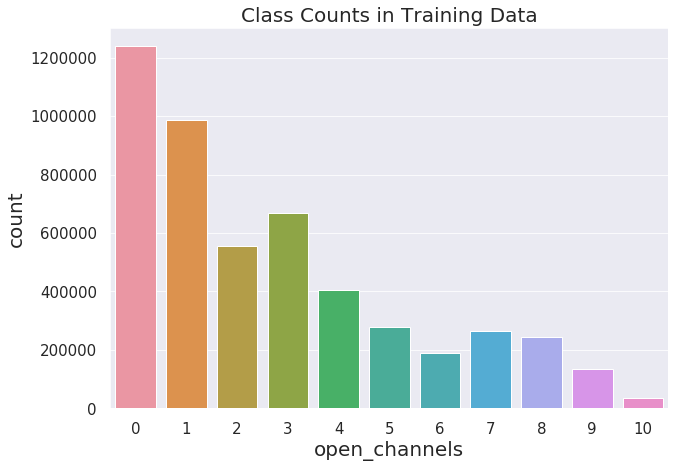

In [6]:
plt.figure(figsize=(10,7))
sns.countplot(train.open_channels)
plt.title('Class Counts in Training Data',size=20)

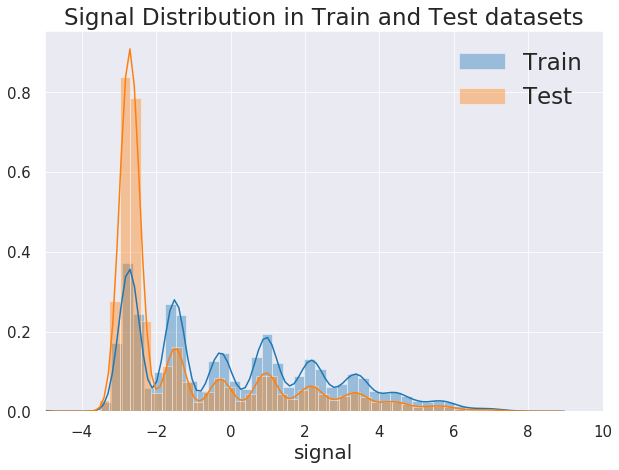

In [7]:
plt.figure(figsize=(10,7))
sns.distplot(train.signal)
sns.distplot(test.signal)
plt.xlim([-5,10])
plt.title('Signal Distribution in Train and Test datasets',size=23)
plt.legend(['Train','Test'],frameon=False)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 1.0, 'Signal vs Open Channels')

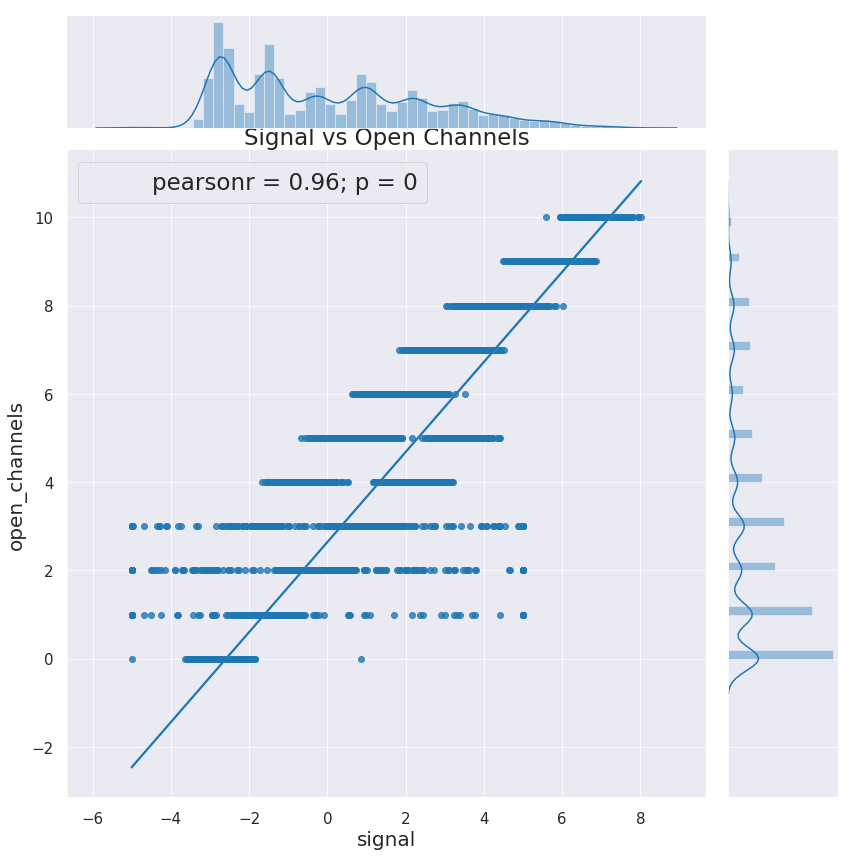

In [8]:
g=sns.jointplot(x='signal', y='open_channels' ,data=train[::100], height=12, kind='reg')
g.annotate(stats.pearsonr)
plt.title('Signal vs Open Channels',size=23)

In [9]:
def BATCH_CORRELATION(df):
    return stats.pearsonr(df.values[:,0], df.values[:,1])[0]

In [10]:
STEP_SIZE=500000
sp=np.arange(0, len(train),STEP_SIZE)
correlation=[BATCH_CORRELATION(train.iloc[s:(s+STEP_SIZE)]) for s in sp]
batches=['Batch {}'.format(i) for i in range(1,11)]
batch_correlations=dict(zip(batches,correlation))

(-1, 10)

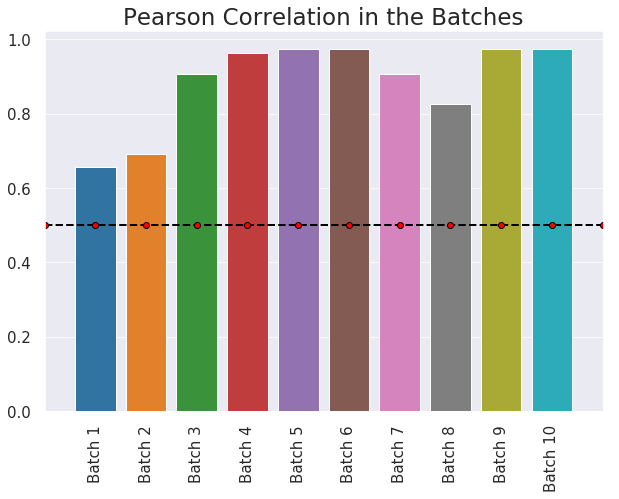

In [11]:
plt.figure(figsize=(10,7))
sns.barplot(data=pd.DataFrame(batch_correlations, index=range(0,10)))
plt.xticks(rotation=90)
plt.title('Pearson Correlation in the Batches',size=23)
xx=np.arange(-1,11)
yy=xx*0 + 0.5
plt.plot(xx,yy, lw=2, ls='--', color='k', marker='o', markerfacecolor='r')
plt.xlim(-1,10)

# Creating Weightes for the Classes

In [13]:
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = list(labels_dict.keys())
    class_weight = dict()
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

In [14]:
class_weight=create_class_weight(dict(train.open_channels.value_counts()))

In [15]:
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[key] for key in training_data.ravel()]
    return np.asarray(sample_weights)

# Reshaping and Splitting the data

In [24]:
sm = SMOTE(random_state=1, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(train.signal.values.reshape(-1,1), train.open_channels.values.ravel())

In [25]:
X_res.shape ,y_res.shape

((6204419, 1), (6204419,))

In [26]:
X_res=X_res[419:]
y_res=y_res[419:]

In [27]:
X_res.shape ,y_res.shape

((6204000, 1), (6204000,))

In [28]:
seq_len = 1000

X_res = X_res.reshape(-1, seq_len, 1)
y_res = y_res.reshape(-1, seq_len, 1)

In [29]:
#seq_len = 1000
#X_res = train.signal.values.reshape(-1, seq_len, 1)
#y_res = train.open_channels.values.reshape(-1, seq_len, 1)

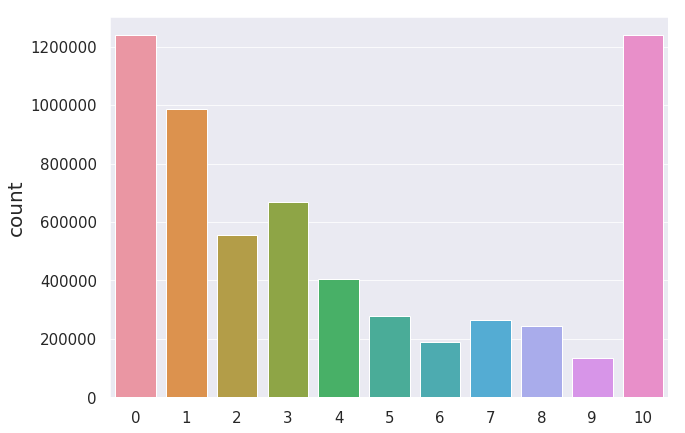

In [30]:
plt.figure(figsize=(10,7))
sns.countplot(y_res.reshape(-1))

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.2)
X_test= test.signal.values.reshape(-1, seq_len, 1)

# Creating a Bi-LSTM Model

In [32]:
X_train.shape

(4963, 1000, 1)

In [34]:
n_units=256
batch=128
n_classes=len(train.open_channels.unique())
inputs = layers.Input(shape=(seq_len, X_train.shape[2]))
outputs = layers.Dense(n_units, activation='linear')(inputs)    
outputs= layers.LSTM(n_units, return_sequences=True)(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs= layers.LSTM(n_units, return_sequences=True)(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.LSTM(n_units, return_sequences=True)(outputs)
outputs = layers.Dense(n_classes, activation='softmax')(outputs)  
model = Model(inputs=inputs, outputs=outputs)
model.compile('adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, 
          batch_size=batch,
          epochs=30,
          callbacks=[ callbacks.ReduceLROnPlateau(), 
                      callbacks.ModelCheckpoint('BiLSTM-N{}-D0.5-B{}.h5'.format(n_units,batch)),
                      callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                      callbacks.CSVLogger(f"BiLSTM-log-Nodes-{n_units}-dropout-0.5-batchsize-{batch}.csv")],
                      validation_data=(X_valid, y_valid), 
                      class_weight=generate_sample_weights(y_train, class_weight)
                      )

Train on 4963 samples, validate on 1241 samples
Epoch 1/30
4963/4963 [==============================] - 21s 4ms/sample - loss: 1.1300 - accuracy: 0.5890 - val_loss: 0.8041 - val_accuracy: 0.6830
Epoch 2/30
4963/4963 [==============================] - 17s 3ms/sample - loss: 0.7726 - accuracy: 0.6884 - val_loss: 0.7393 - val_accuracy: 0.7019
Epoch 3/30
4963/4963 [==============================] - 17s 3ms/sample - loss: 0.7091 - accuracy: 0.7118 - val_loss: 0.6327 - val_accuracy: 0.7329
Epoch 4/30
4963/4963 [==============================] - 17s 3ms/sample - loss: 0.5988 - accuracy: 0.7490 - val_loss: 0.5395 - val_accuracy: 0.7749
Epoch 5/30
4963/4963 [==============================] - 17s 3ms/sample - loss: 0.4912 - accuracy: 0.8034 - val_loss: 0.4061 - val_accuracy: 0.8508
Epoch 6/30
4963/4963 [==============================] - 17s 3ms/sample - loss: 0.3410 - accuracy: 0.8778 - val_loss: 0.2365 - val_accuracy: 0.9262
Epoch 7/30
4963/4963 [==============================] - 17s 3ms/sample

# Evaluate Bi-LSTM model

In [35]:
model.load_weights('BiLSTM-N256-D0.5-B128.h5')
valid_pred = model.predict(X_valid, batch_size=128).argmax(axis=-1)
print('Accuracy Score : {}'.format(accuracy_score(y_valid.reshape(-1), valid_pred.reshape(-1))))
print('F1 Score : {}'.format(f1_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Precision Score : {}'.format(precision_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Recall Score : {}'.format(recall_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))

Accuracy Score : 0.9692514101531023
F1 Score : 0.9393087464479225
Precision Score : 0.9397573584053949
Recall Score : 0.9389226929417588


In [36]:
conf_mat=confusion_matrix(y_valid.reshape(-1), valid_pred.reshape(-1))
_ , counts= np.unique(y_valid, return_counts=True)
normalized_conf_mat = conf_mat/counts

Text(0.5, 1.0, 'Confusion Matrix showing performance for each class')

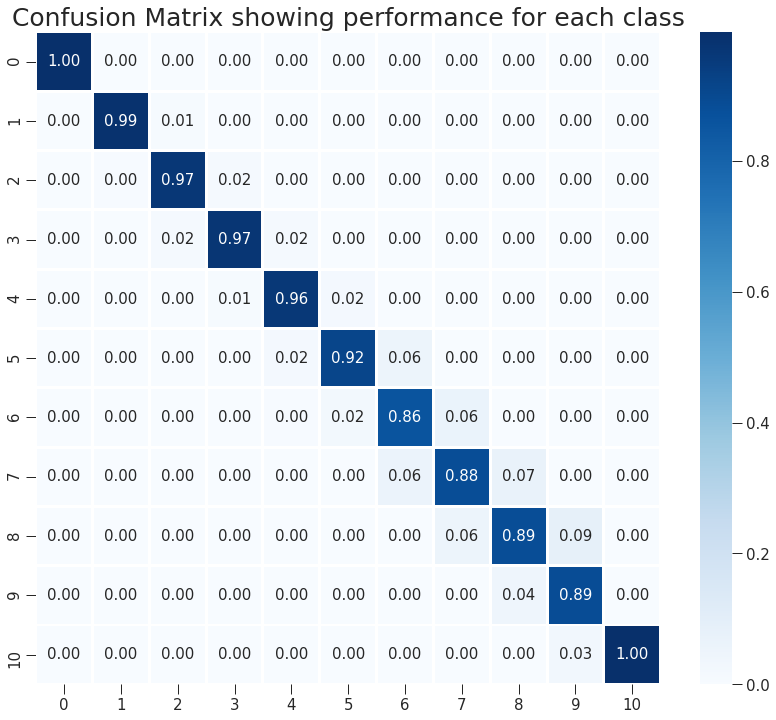

In [37]:
sns.set_style('ticks')
plt.figure(figsize=(14,12))
sns.heatmap(normalized_conf_mat, lw=2, cmap='Blues', annot=True, fmt='.2f', annot_kws={'size':15} )
plt.title('Confusion Matrix showing performance for each class',size=25)

Text(0, 0.5, 'Performance')

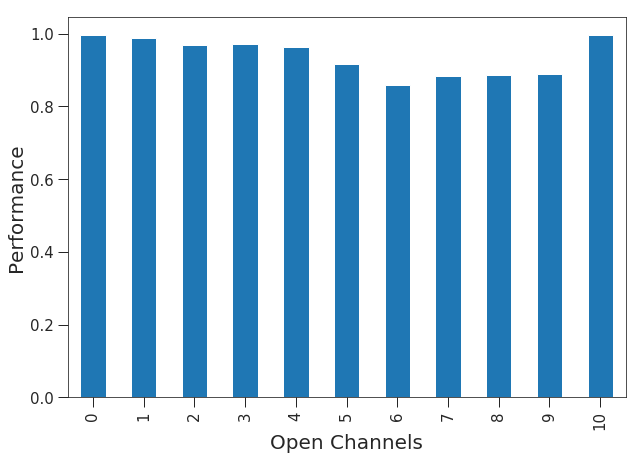

In [38]:
class_performance = dict(zip(_, np.diagonal(normalized_conf_mat)))
class_performance=pd.DataFrame(class_performance, index=range(0,1))
class_performance.T.plot.bar(legend=False,figsize=(10,7))
plt.xlabel('Open Channels')
plt.ylabel('Performance')

In [39]:
test_pred = model.predict(X_test, batch_size=128).argmax(axis=-1)
submission.open_channels = test_pred.reshape(-1)
submission.to_csv('submission.csv', index=False)